**STOCKS ROBOT**

* The purpose of this project is to maximize the profit from the stocks market during 2005-2021.
* I only chose 3 popular tech stocks (GOOGL, AMZN, AAPL) for this project.

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# install libraries
!pip install yfinance
!pip install stable-baselines3
!pip install optuna
url = "https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files"
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

     |████████████████████████████████| 63 kB 323 kB/s 
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=0a377c7e7e88defa4e5a013668c895d0c073c3e125c37d4c0c29aacb6ac61f84
  Stored in directory: /root/.cache/pip/wheels/34/ba/79/c0260c6f1a03f420ec7673eff9981778f293b9107974679e36
Successfully built multitasking
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
beatrix-jupyterlab 3.1.1 requires google-cloud-bigquery-storage, which is not installed.
gcsfs 2021.8.1 requires fsspec==2021.08.1, but you have fsspec 2021.10.0 which is incompatible.
apache-beam 2.32.0 requires dill<0.3.2,>=0.3

* I also downloaded indices that might correlate to these tech stocks such as NASDAQ index. They may help with the prediction

In [2]:
#loading data
import talib
import yfinance as yf 

stocks = ['GOOGL'
          , 'AMZN'
          , 'AAPL'
         ]
          
index = [
          '^GSPC',
          '^IXIC',
          '^TNX'
         ]
yf_interval = "1d"

df_o = yf.download(
        tickers = stocks+index,            
        interval = yf_interval,  
        start="2005-01-01"
        , end="2021-12-31"
        , group_by = 'ticker',     
        auto_adjust = True,      
        prepost = True,          
        threads = True,          
        proxy = None)            

[*********************100%***********************]  6 of 6 completed


In [3]:
# renaming columns
df = df_o.copy()
idx_name = {'^IXIC':'NASDAQ', '^TNX':'BOND', '^GSPC':'SP500'}
df.columns = [(i[0] if i[0] not in idx_name else idx_name[i[0]])+"_"+i[1] for i in df.columns]

In [4]:
#################################################### EDA ################################################

In [5]:
df.head()

,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Volume,BOND_Open,BOND_High,BOND_Low,BOND_Close,BOND_Volume,...,SP500_Open,SP500_High,SP500_Low,SP500_Close,SP500_Volume,GOOGL_Open,GOOGL_High,GOOGL_Low,GOOGL_Close,GOOGL_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,44.950001,45.439999,44.209999,44.520000,10446500,4.257,4.270,4.203,4.220,0.0,...,1211.920044,1217.800049,1200.319946,1202.079956,1510800000,98.798798,101.921921,97.827827,101.456459,31656712
2005-01-04,42.669998,43.259998,41.500000,42.139999,19418500,4.212,4.307,4.197,4.283,0.0,...,1202.079956,1205.839966,1185.390015,1188.050049,1721000000,100.800804,101.566566,96.836838,97.347343,27484288
2005-01-05,41.570000,42.759998,41.560001,41.770000,8354200,4.298,4.304,4.255,4.277,0.0,...,1188.050049,1192.729980,1183.719971,1183.739990,1738900000,96.821823,98.548546,96.211212,96.851852,16456727
2005-01-06,41.810001,42.250000,40.900002,41.049999,8700900,4.288,4.298,4.257,4.272,0.0,...,1183.739990,1191.630005,1183.270020,1187.890015,1569100000,97.637634,98.048050,93.953957,94.369370,20753426
2005-01-07,41.380001,42.689999,41.160000,42.320000,9836600,4.255,4.313,4.148,4.285,0.0,...,1187.890015,1192.199951,1182.160034,1186.189941,1477900000,95.415413,97.222221,94.484482,97.022018,19306474


In [6]:
df.shape

(4279, 30)

In [7]:
# data type and missing value
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4279 entries, 2005-01-03 to 2021-12-30
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AMZN_Open      4279 non-null   float64
 1   AMZN_High      4279 non-null   float64
 2   AMZN_Low       4279 non-null   float64
 3   AMZN_Close     4279 non-null   float64
 4   AMZN_Volume    4279 non-null   int64  
 5   BOND_Open      4273 non-null   float64
 6   BOND_High      4273 non-null   float64
 7   BOND_Low       4273 non-null   float64
 8   BOND_Close     4273 non-null   float64
 9   BOND_Volume    4273 non-null   float64
 10  NASDAQ_Open    4279 non-null   float64
 11  NASDAQ_High    4279 non-null   float64
 12  NASDAQ_Low     4279 non-null   float64
 13  NASDAQ_Close   4279 non-null   float64
 14  NASDAQ_Volume  4279 non-null   int64  
 15  AAPL_Open      4279 non-null   float64
 16  AAPL_High      4279 non-null   float64
 17  AAPL_Low       4279 non-null   flo

In [8]:
# checking data range
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AMZN_Open,4279.0,7.701178e+02,9.882689e+02,2.609000e+01,8.422000e+01,2.820000e+02,1.005975e+03,3.744000e+03
AMZN_High,4279.0,7.782818e+02,9.986617e+02,2.630000e+01,8.545500e+01,2.848700e+02,1.010025e+03,3.773080e+03
AMZN_Low,4279.0,7.611174e+02,9.766780e+02,2.576000e+01,8.279500e+01,2.797400e+02,9.976100e+02,3.696790e+03
AMZN_Close,4279.0,7.699299e+02,9.876457e+02,2.607000e+01,8.430000e+01,2.821000e+02,1.002970e+03,3.731410e+03
AMZN_Volume,4279.0,5.656299e+06,4.753164e+06,8.813000e+05,3.145350e+06,4.545500e+06,6.710000e+06,1.043292e+08
BOND_Open,4273.0,2.756981e+00,1.119369e+00,4.840000e-01,1.919000e+00,2.564000e+00,3.593000e+00,5.276000e+00
BOND_High,4273.0,2.786175e+00,1.122261e+00,5.380000e-01,1.944000e+00,2.595000e+00,3.645000e+00,5.316000e+00
BOND_Low,4273.0,2.727386e+00,1.116595e+00,3.980000e-01,1.892000e+00,2.534000e+00,3.540000e+00,5.218000e+00
BOND_Close,4273.0,2.756159e+00,1.118897e+00,4.990000e-01,1.915000e+00,2.561000e+00,3.595000e+00,5.248000e+00
BOND_Volume,4273.0,1.532015e+03,1.541089e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.597000e+05


In [9]:
# dropping column with wrong data
df = df.drop(['BOND_Volume'],axis=1)

# checking duplicates
df = df.reset_index()
df = df.drop_duplicates(subset=['Date'])
df = df.set_index('Date')
df.shape

(4279, 29)

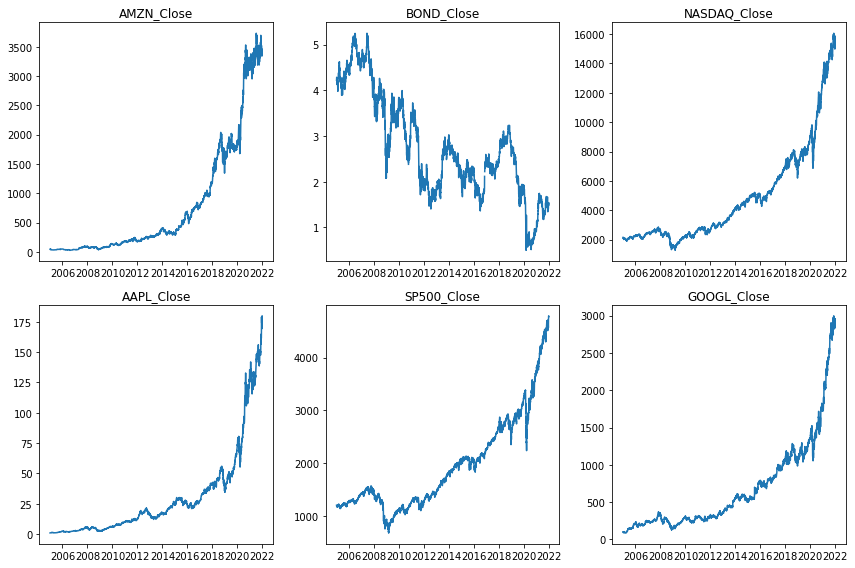

In [10]:
# plotting price
import matplotlib.pyplot as plt

ncols=3
nrows=(len(stocks)+len(index))//ncols

close = [i for i in df.columns if '_Close' in i]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8),
                        )
cnt = 0
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].plot(df[close[cnt]])
        axes[i,j].set_title(close[cnt])
        cnt += 1

fig.tight_layout()



<AxesSubplot:>

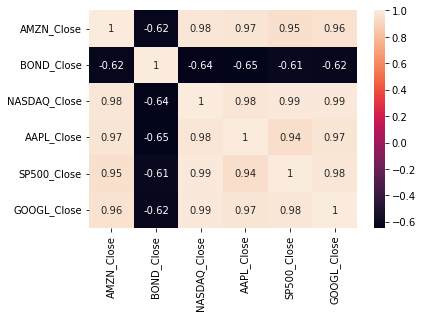

In [11]:
# correlation
import seaborn as sns
sns.heatmap(df[close].corr(), annot=True)

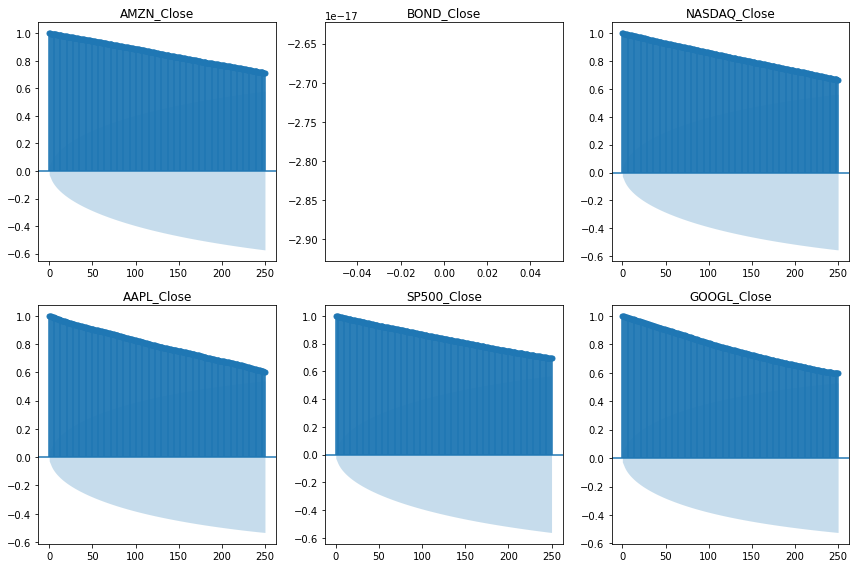

In [12]:
# ACF
from statsmodels.graphics.tsaplots import plot_acf

ncols=3
nrows=(len(stocks)+len(index))//ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
cnt = 0
for i in range(nrows):
    for j in range(ncols):
        plot_acf(df[close[cnt]],lags=250, ax=axes[i, j])
        axes[i,j].set_title(close[cnt])
        cnt += 1

fig.tight_layout()

In [13]:
# stationarity
from statsmodels.tsa.stattools import adfuller

def adf_test(df, col):
    print("Results of Dickey-Fuller Test:", col)
    dftest = adfuller(df[col], autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

for col in [stocks+'_Close' for stocks in stocks]:
    adf_test(df, col)
    print('\n')

Results of Dickey-Fuller Test: GOOGL_Close
Test Statistic                    4.719278
p-value                           1.000000
#Lags Used                       30.000000
Number of Observations Used    4248.000000
Critical Value (1%)              -3.431890
Critical Value (5%)              -2.862221
Critical Value (10%)             -2.567132
dtype: float64


Results of Dickey-Fuller Test: AMZN_Close
Test Statistic                    2.722437
p-value                           0.999088
#Lags Used                       31.000000
Number of Observations Used    4247.000000
Critical Value (1%)              -3.431891
Critical Value (5%)              -2.862221
Critical Value (10%)             -2.567132
dtype: float64


Results of Dickey-Fuller Test: AAPL_Close
Test Statistic                    4.578776
p-value                           1.000000
#Lags Used                       27.000000
Number of Observations Used    4251.000000
Critical Value (1%)              -3.431889
Critical Value (5%)   

* Here I added some common technical indicators that will help with the prediction

In [14]:
# adding extra features

# rsi
from talib import RSI

for i in stocks:
    df[i+'_rsi'] = RSI(df[i+'_Close'], timeperiod=14)

# cci
def CCI(df_main, i, ndays): 
    df = df_main.copy()
    df[i+'_TP'] = (df[i+'_High'] + df[i+'_Low'] + df[i+'_Close']) / 3 
    df[i+'_sma'] = df[i+'_TP'].rolling(ndays).mean()
    df[i+'_mad'] = df[i+'_TP'].rolling(ndays).apply(lambda x: pd.Series(x).mad())
    df[i+'_cci'] = (df[i+'_TP'] - df[i+'_sma']) / (0.015 * df[i+'_mad']) 
    return df[i+'_cci']

for i in stocks:
    df[i+'_cci'] = CCI(df, i, 20)

# macd
for i in stocks:
    short_ema =  df[i+'_Close'].ewm(span=12, adjust=False).mean()
    long_ema = df[i+'_Close'].ewm(span=26, adjust=False).mean()
#     signal = df[i+'_Close'].ewm(span=9, adjust=False).mean()
    df[i+'_macd'] =  short_ema - long_ema
#     df[i+'_short_ema'] = short_ema

# removing rows upto the needed history range of extra features
df = df.iloc[26:,:]

* I used the data from 2005 to 2019 to train the model
* year 2020 was used for validation, and 2021 for testing.
* 60 days of price history was used as features for the deep learning model in the next section

In [15]:
# train test split
df_train = df.loc[:'2019']
df_val = df.loc['2020']
df_test = df.loc['2021']

# adding prior sequences for val and test
length = 60
df_val = pd.concat([df_train.iloc[-length:,:],df_val])
df_test = pd.concat([df_val.iloc[-length:,:],df_test])

print(f'train/val/test: {len(df_train)}/{len(df_val)}/{len(df_test)}')

train/val/test: 3749/313/311


* First I only used the Close price of each stocks as features to the models.

In [16]:
# missing  value
df_train['BOND_Close'] = df_train['BOND_Close'].interpolate()

# feature selection
select_feat = ['Close',
#                'rsi',
#                'cci',
#                'macd'
              ]

feat_ls = [stocks+'_'+feat for stocks in stocks for feat in select_feat]

out_col_ls = feat_ls = [stocks+'_Close' for stocks in stocks]

df_train = df_train[feat_ls]
df_val = df_val[feat_ls]
df_test = df_test[feat_ls]

def xy_split(df):
    return df[feat_ls], df[out_col_ls]

X_train, y_train = xy_split(df_train)
X_val, y_val = xy_split(df_val)
X_test, y_test = xy_split(df_test)

# scaling
from sklearn.preprocessing import MinMaxScaler
sc_X = MinMaxScaler()
sc_X.fit(X_train)
X_train = sc_X.transform(X_train)
X_val = sc_X.transform(X_val)
X_test = sc_X.transform(X_test)

sc_y = MinMaxScaler()
sc_y.fit(y_train)
y_train = sc_y.transform(y_train)
y_val = sc_y.transform(y_val)
y_test = sc_y.transform(y_test)

# remove 0
selected_idx = [i for i in range(len(X_train)) if X_train[i,0]>0 and X_train[i,1]>0 and X_train[i,2]>0]
X_train = X_train[selected_idx]
y_train = y_train[selected_idx]


In [17]:
############################################### MODELING  ##########################################

I compared 3 strategies for the trading
1. Baseline model
2. Day trading using deep learning to forecast the next day price
3. Reinforcement learning

First let's come up with a baseline model that utilizes a simple strategy which is to just buy and hold

In [18]:
########## 1. BASELINE MODEL (MODEL 0)

final asset:  41.81855156280458


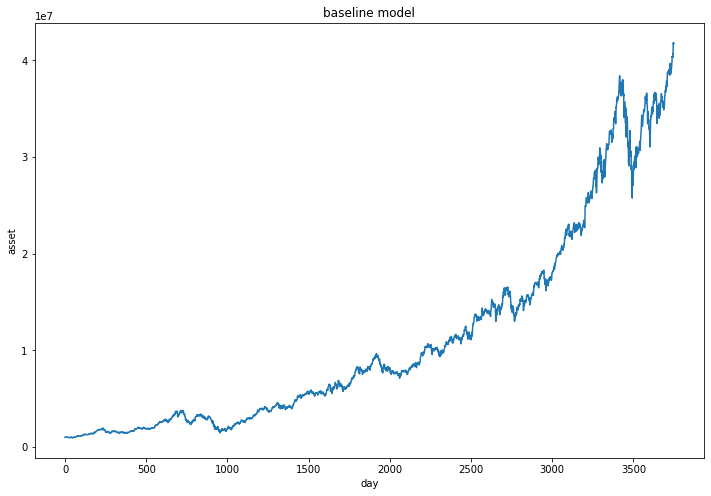

In [19]:
# buy and hold on training set

INITIAL_CASH = 1000000

asset_memory = [INITIAL_CASH]
each_stocks = INITIAL_CASH/3
shares = [each_stocks//df_train.iloc[0,i*len(select_feat)] for i in range(len(stocks))]
rem_cash = INITIAL_CASH-sum(shares[i] * df_train.iloc[0,i*len(select_feat)] for i in range(len(stocks)))
for day in range(1,len(df_train)):
    cur_asset = rem_cash + sum(shares[i] * df_train.iloc[day,i*len(select_feat)] for i in range(len(stocks)))
    asset_memory.append(cur_asset)
    
# plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('baseline model')
plt.xlabel('day')
plt.ylabel('asset')
plt.plot(np.arange(len(asset_memory)), asset_memory)
print('final asset: ', asset_memory[-1]/10**6)

final asset:  1.6304393465576172


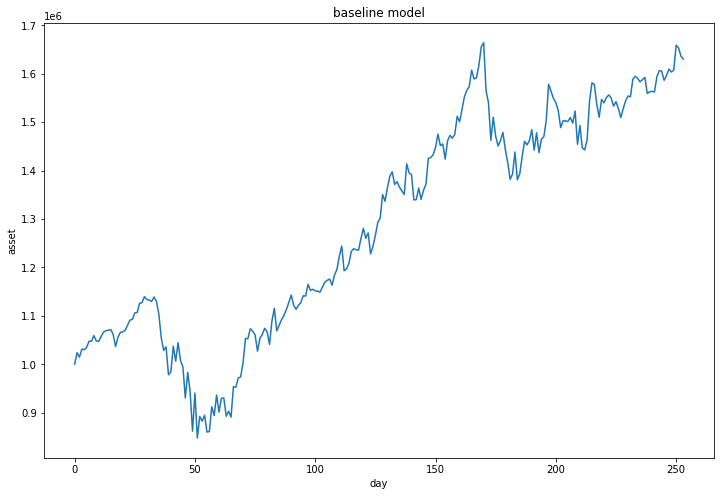

In [20]:
# buy and hold on val set

INITIAL_CASH = 1000000

asset_memory = [INITIAL_CASH]
each_stocks = INITIAL_CASH/3
shares = [each_stocks//df_val.iloc[length-1,i*len(select_feat)] for i in range(len(stocks))]
rem_cash = INITIAL_CASH-sum(shares[i] * df_val.iloc[length-1,i*len(select_feat)] for i in range(len(stocks)))
for day in range(length,len(df_val)):
    cur_asset = rem_cash + sum(shares[i] * df_val.iloc[day,i*len(select_feat)] for i in range(len(stocks)))
    asset_memory.append(cur_asset)
    
# plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.title('baseline model')
plt.xlabel('day')
plt.ylabel('asset')
plt.plot(np.arange(len(asset_memory)), asset_memory)
print('final asset: ', asset_memory[-1]/10**6)

* After all the buy and hold strategy is quite strong. I would achieve 63% profit 1 just 1 year!

In [21]:
########### STRATEGY 2: DAY TRADING USING DEEP LEARNING FORECAST

In [22]:
# pipeline building
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from itertools import combinations
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
import time
import itertools
from numpy.random import choice
import os
from tensorflow.keras.metrics import RootMeanSquaredError

# generator
def build_gen(length, batch_size):
    train_gen = TimeseriesGenerator(X_train,y_train, length=length, batch_size=batch_size)
    val_gen = TimeseriesGenerator(X_val,y_val, length=length, batch_size=batch_size)
    
    return train_gen, val_gen

# saving model
import pickle

def save_model(dat_name, mod_name, model, log):
    if not os.path.exists('./data'): os.mkdir('./data')
    model.save('./model/stocks_'+dat_name+'_'+mod_name)
    # saving log
    pickle_out = open('./model/stocks_'+dat_name+'_'+mod_name+'_log',"wb")
    pickle.dump(log, pickle_out)
    pickle_out.close()

# plotting
def plot_curve(log):
    hist = log['history']
    epochs = np.arange(len(hist['loss']))
    
    plt.figure(figsize=(12,8))
    plt.title(str(log['params']))
    plt.ylabel('mape')
    plt.xlabel('epoch')
    plt.plot(epochs, hist['loss'])
    plt.plot(epochs, hist['val_loss'])
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.figure(figsize=(12,8))
    plt.title(str(log['params']))
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.plot(epochs, hist['root_mean_squared_error'])
    plt.plot(epochs, hist['val_root_mean_squared_error'])
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [23]:
########## SIMPLE LSTM MODEL (MODEL 1)

* The strategy is to do a day trade by predicting next day price and buy/sell stocks accordingly.
* First I tried a simple LSTM model with random search for hyperparameters
* The features to this model is 60 days price history. 
* The outputs are the predicted price of the 3 stocks for the next day (only 1 timestep forward)
* I used walk forward validation approach to test model performance on the validation set.
* In actual operation, the model needs to be retrained on the new data everyday. But that would be too time consuming for the validation with random hyperparameter search. So, I skipped the retraining part.
* Note that, since I already run the random search once in another notebook, i will only show the result of the best param in this section.

2022-05-16 07:21:10.089186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 07:21:10.187143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 07:21:10.188140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 07:21:10.190275: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

training params: {'n_lstm': 140, 'batch_size': 8, 'lr': 1e-05}


2022-05-16 07:21:13.160699: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-16 07:21:15.463874: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


461/461 [==============================] - 7s 7ms/step - loss: 99.7115 - root_mean_squared_error: 0.3668 - val_loss: 89.0557 - val_root_mean_squared_error: 1.1177
Epoch 2/50
461/461 [==============================] - 3s 6ms/step - loss: 81.0218 - root_mean_squared_error: 0.3226 - val_loss: 73.2895 - val_root_mean_squared_error: 0.9182
Epoch 3/50
461/461 [==============================] - 3s 6ms/step - loss: 76.6326 - root_mean_squared_error: 0.2650 - val_loss: 41.4875 - val_root_mean_squared_error: 0.5348
Epoch 4/50
461/461 [==============================] - 3s 6ms/step - loss: 51.6757 - root_mean_squared_error: 0.1682 - val_loss: 11.3703 - val_root_mean_squared_error: 0.1840
Epoch 5/50
461/461 [==============================] - 3s 6ms/step - loss: 42.5163 - root_mean_squared_error: 0.1223 - val_loss: 17.7085 - val_root_mean_squared_error: 0.2628
Epoch 6/50
461/461 [==============================] - 3s 6ms/step - loss: 35.4726 - root_mean_squared_error: 0.1123 - val_loss: 20.4348 - val

2022-05-16 07:21:58.608643: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


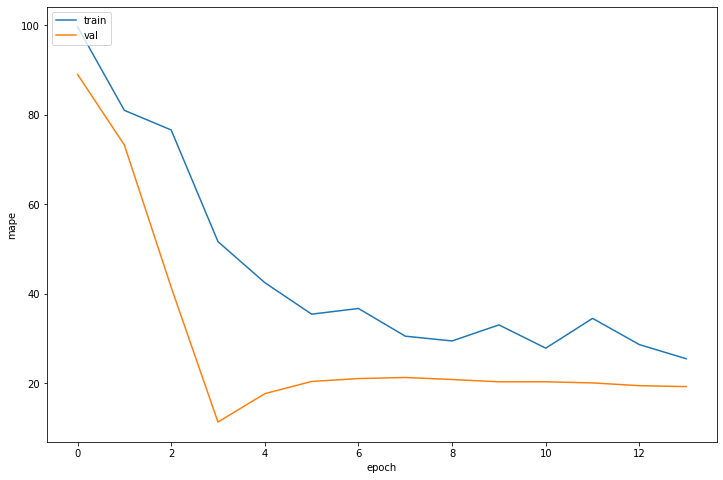

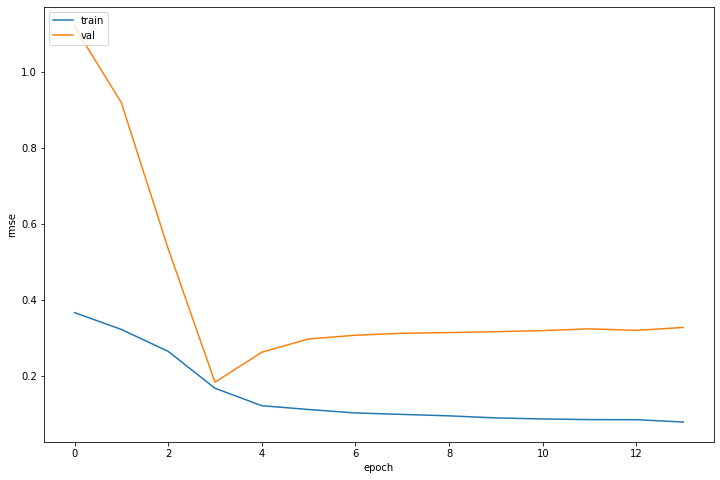

In [24]:
epochs = 50
rmse = RootMeanSquaredError()

# model building
def build_lstm(n_lstm, length, lr):
    model = Sequential()
    model.add(LSTM(n_lstm,input_shape=(length,len(feat_ls))))
    model.add(Dense(int(n_lstm/2), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(out_col_ls)))
    
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mape' ,metrics=[rmse]
                 )
#     model.summary()
    
    return model


# random search param
import sys

def build_config():
       
    n_lstm = np.arange(20,150,30)
    batch_size = np.array([8,16,32])
#     length = np.arange(5,61,5)
    lr = [1e-3,1e-4,1e-5]
    
    samples = 10
    config = []
    i = 0
    lim = 100
    
    while i < samples:
        params = {}
        params['n_lstm'] = choice(n_lstm)
        params['batch_size'] = choice(batch_size)
#         params['length'] = length
        params['lr'] = choice(lr)
    
        if params not in config:
            config.append(params)
            i += 1
        if i == lim: sys.exit('error')
        
    return config

# training
def train_model(dat_name,mod_name):
    
    best_model, lowest_loss, best_history, best_params = None, 1000, None, None
    log = {}
    
    # iterate over configs
#     for params in build_config():
    for params in [{'n_lstm': 140, 'batch_size': 8, 'lr': 1e-05}]:
        print(f'training params: {params}')
        
        n_lstm = params['n_lstm']
        batch_size = params['batch_size']
#         length = params['length']
        lr = params['lr']
        
        train_gen, val_gen = build_gen(length, batch_size)
        model = build_lstm(n_lstm, length, lr)
        
        # early stopping
        early_stop = EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)

        start = time.time()
        history = model.fit(train_gen
                           ,epochs=epochs
                           ,validation_data=val_gen
                           ,callbacks=[early_stop]
                           ,verbose=1
                           )
        end = time.time()
        train_time = end-start
        
        # checking performance
        loss = min(history.history['val_loss'])
        print('performance: ', loss)
        
        if loss < lowest_loss:
            lowest_loss = loss
            log['best_history'] = history.history
            log['best_params'] = params
            log['best_time'] = train_time
            save_model(dat_name, mod_name, model, log)
        

# training
train_model('d1','m0')

# plotting curve
import pickle
import matplotlib.pyplot as plt

log = pickle.load(open('./model/stocks_d1_m0_log','rb'))
res = log['best_history']
epochs = np.arange(len(res['loss']))
plt.figure(figsize=(12,8))
plt.ylabel('mape')
plt.xlabel('epoch')
plt.plot(epochs, res['loss'])
plt.plot(epochs, res['val_loss'])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12,8))
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.plot(epochs, res['root_mean_squared_error'])
plt.plot(epochs, res['val_root_mean_squared_error'])
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [25]:
########## CONVO LSTM ARCHITECTURE (MODEL 2)

* Let us try incorporating the CNN component to improve the model performance.

training params: {'n_lstm': 50, 'n_filter': 64, 'kernel_size': 3, 'batch_size': 16, 'lr': 0.01, 'sub_len': 20}
performance:  90.5032730102539


training params: {'n_lstm': 20, 'n_filter': 64, 'kernel_size': 3, 'batch_size': 8, 'lr': 0.0001, 'sub_len': 20}
performance:  14.194766998291016


training params: {'n_lstm': 110, 'n_filter': 64, 'kernel_size': 3, 'batch_size': 32, 'lr': 0.0001, 'sub_len': 5}
performance:  14.265684127807617


training params: {'n_lstm': 80, 'n_filter': 64, 'kernel_size': 3, 'batch_size': 8, 'lr': 0.01, 'sub_len': 10}
performance:  87.99253845214844


training params: {'n_lstm': 110, 'n_filter': 64, 'kernel_size': 3, 'batch_size': 32, 'lr': 0.001, 'sub_len': 20}
performance:  12.327329635620117


training params: {'n_lstm': 80, 'n_filter': 64, 'kernel_size': 3, 'batch_size': 8, 'lr': 0.001, 'sub_len': 20}
performance:  9.844878196716309


training params: {'n_lstm': 80, 'n_filter': 64, 'kernel_size': 3, 'batch_size': 32, 'lr': 0.001, 'sub_len': 20}
performance:

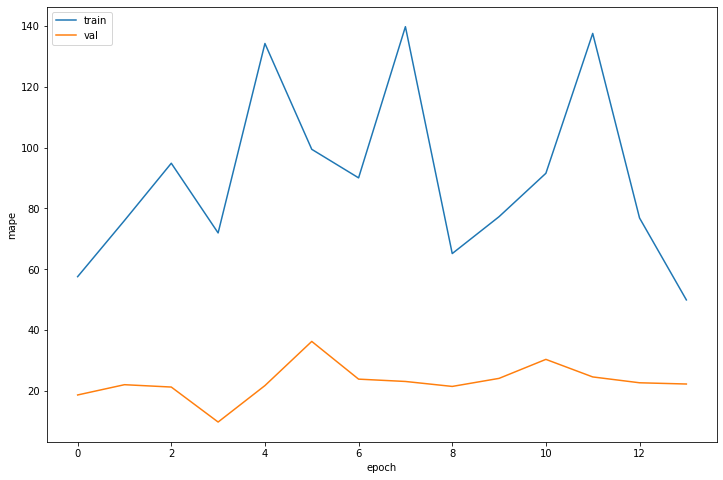

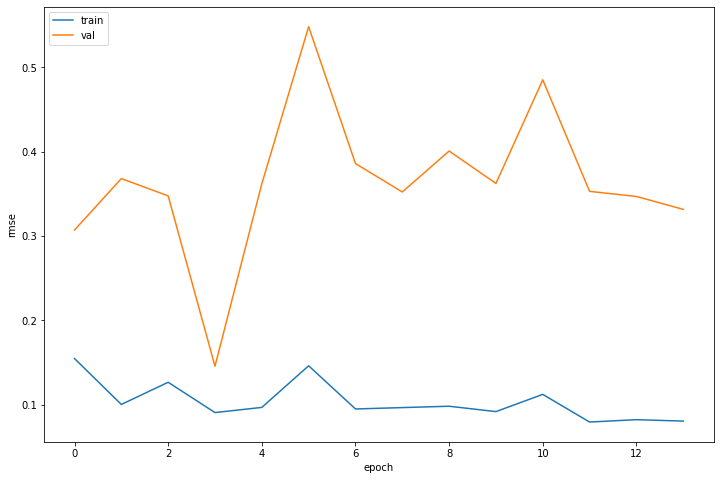

In [26]:
from tensorflow.keras.layers import TimeDistributed, Dense, Flatten,\
    Conv1D, MaxPooling1D, RepeatVector, Reshape, Dropout
from numpy import array
from numpy import hstack
from tensorflow.keras.models import Sequential
import pickle

epochs = 50
drop_rate = 0.2

# build model
def build_model(kernel_size, n_filter, length, lr, n_lstm, sub_len):
    
    model = Sequential()
    model.add(Reshape((int(length/sub_len),sub_len,  len(feat_ls)), 
                      input_shape=(length, len(feat_ls)) )
             )

    model.add(TimeDistributed(Conv1D(filters=n_filter, 
                                     kernel_size=int(kernel_size),
                                     activation='relu'
                                    )))                                   
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(n_lstm, activation='relu', return_sequences=True))
    model.add(LSTM(n_lstm, activation='relu'))

    model.add(Dense(n_lstm/2))
    model.add(Dropout(drop_rate))
    model.add(Dense(len(feat_ls)))
    
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mape' ,metrics=[rmse])

    return model


# GRID SEARCH PARAMETERS
def build_config():
    
    n_lstm = np.arange(20,150,30)
    n_filter = np.array([64])
    kernel_size = np.array([3])
    batch_size = np.array([8,16,32])
#     length = np.arange(5,91,15)
    lr = [1e-2,1e-3,1e-4,1e-5]
    sub_len = [5,10,15,20]
    
    samples = 10
    
    config = []
    
    i = 0
    
    while i < samples:
        
        params = {}
        params['n_lstm'] = choice(n_lstm)
        params['n_filter'] = choice(n_filter)
        params['kernel_size'] = choice(kernel_size)
        params['batch_size'] = choice(batch_size)
#         params['length'] = 80
        params['lr'] = choice(lr)
        params['sub_len'] = choice(sub_len)
        
        if params not in config:
            config.append(params)
            i += 1
        
    return config

# training
def train_model(dat_name,mod_name):
    
#     logging
    lowest_loss, best_history, best_params, best_time = 1000, None, None, None
    log = {}
    
    # iterate over configs
    for params in build_config():
#     for params in [{'n_filter': 64, 'kernel_size': 3, 'batch_size': 8, 'lr': 1e-05}]:
        print('training params: {a}'.format(a=params))
        
        n_lstm = params['n_lstm']
        n_filter = params['n_filter']
        kernel_size = params['kernel_size']
        batch_size = params['batch_size']
        lr = params['lr']
        sub_len = params['sub_len']
        
        train_gen, val_gen = build_gen(length, batch_size)

        
        model = build_model(kernel_size, n_filter, length, lr, n_lstm, sub_len)
#         model.summary()
        
        # early stopping
        early_stop = EarlyStopping(monitor='val_loss',patience=10,  restore_best_weights=True)
        
        start = time.time()
        history = model.fit(train_gen
                                       ,epochs=epochs
                                       ,validation_data=val_gen
                                       ,callbacks=[early_stop]
                                       ,verbose=0
                                       )
        
        end = time.time()
        train_time = end-start
        
        # CHECKING MODEL PERFORMANCE
        loss = min(history.history['val_loss'])
        print('performance: ', loss)
        print('\n')
        
        if loss < lowest_loss:
            lowest_loss = loss
            log['best_history'] = history.history
            log['best_params'] = params
            log['best_time'] = train_time
            save_model(dat_name, mod_name, model, log)
        
        
# training
train_model('d1','m2')

# # plotting curve

import pickle
import matplotlib.pyplot as plt

log = pickle.load(open('./model/stocks_d1_m2_log','rb'))
res = log['best_history']
epochs = np.arange(len(res['loss']))
plt.figure(figsize=(12,8))
plt.ylabel('mape')
plt.xlabel('epoch')
plt.plot(epochs, res['loss'])
plt.plot(epochs, res['val_loss'])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12,8))
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.plot(epochs, res['root_mean_squared_error'])
plt.plot(epochs, res['val_root_mean_squared_error'])
plt.legend(['train', 'val'], loc='upper left')
plt.show()


* Seems that performance has dropped compared with the simple LSTM model

In [27]:
############# 1D CNN WITH TPE HYPERPARAMETER OPTIMIZATION (MODEL 3)

* Now let's try to change the architecture to only the CNN
* This time I also used TPE hyperparameter optimization

In [28]:
from numpy import array
from numpy import hstack
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Input, concatenate, BatchNormalization
from tensorflow.keras.metrics import RootMeanSquaredError
import sys
import tensorflow as tf
import optuna
from optuna.integration import TFKerasPruningCallback

rmse = RootMeanSquaredError()
epochs = 200

# build cnn model
def build_cnn(kernel_size, n_filter, length, lr):

    n_hidden = length*n_filter/4
    
    model = Sequential()
    model.add(Conv1D(filters=n_filter, 
                     kernel_size=int(kernel_size),
                     activation='relu', 
                     input_shape=(length, len(feat_ls))
                    )
             )
    model.add(MaxPooling1D(pool_size=2))
#     model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(n_hidden,activation='relu'))
#     model.add(BatchNormalization())
    model.add(Dense(len(out_col_ls))) 
    
    optimizer = Adam(learning_rate=lr)
    
    model.compile(optimizer=optimizer, loss='mape' ,metrics=[rmse])
#     model.summary()
    
    return model

lowest_loss = np.inf
best_model = None

def objective(trial):
    
    global best_model
    
    batch_size = trial.suggest_int('batch_size', 1, 2, log=False)
    batch_size = 2**batch_size
    lr = trial.suggest_float('lr', 1e-6, 1e-4, log=True)
    kernel_size = trial.suggest_int('kernel_size', 1, 2, log=False)
    kernel_size = 2**kernel_size
    n_filter = trial.suggest_int('n_filter', 5, 7, log=False)
    n_filter = 2**n_filter
    
    train_gen, val_gen = build_gen(length=length, batch_size=batch_size)
    model = build_cnn(kernel_size=kernel_size, n_filter=n_filter, length=length, lr=lr)

    history = model.fit(train_gen
                               ,epochs=epochs
                               ,validation_data=val_gen
                               ,verbose=0
                               , callbacks = TFKerasPruningCallback(trial, 'val_loss')
                               )
    
    val_loss = history.history['val_loss'][-1]
    
    if val_loss < lowest_loss:
        best_model = model

    return val_loss

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=20)


[I 2022-05-16 07:39:04,307] A new study created in memory with name: no-name-ad169e42-4d91-4dea-b65d-0d0be9e09270
[I 2022-05-16 07:54:32,482] Trial 0 finished with value: 4.178459644317627 and parameters: {'batch_size': 1, 'lr': 8.002785752707014e-06, 'kernel_size': 2, 'n_filter': 6}. Best is trial 0 with value: 4.178459644317627.
[I 2022-05-16 08:02:25,558] Trial 1 finished with value: 15.042052268981934 and parameters: {'batch_size': 2, 'lr': 8.282239868732525e-05, 'kernel_size': 2, 'n_filter': 6}. Best is trial 0 with value: 4.178459644317627.
[I 2022-05-16 08:10:25,357] Trial 2 finished with value: 5.000672340393066 and parameters: {'batch_size': 2, 'lr': 1.8162951153003806e-06, 'kernel_size': 1, 'n_filter': 5}. Best is trial 0 with value: 4.178459644317627.
[I 2022-05-16 08:26:24,763] Trial 3 finished with value: 7.651201248168945 and parameters: {'batch_size': 1, 'lr': 8.443405869316145e-05, 'kernel_size': 2, 'n_filter': 5}. Best is trial 0 with value: 4.178459644317627.
[I 2022-

In [29]:
# optimization summary
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 20
Best trial:
  Value: 3.7771449089050293
  Params: 
    batch_size: 2
    lr: 1.4211623407929328e-05
    kernel_size: 1
    n_filter: 7


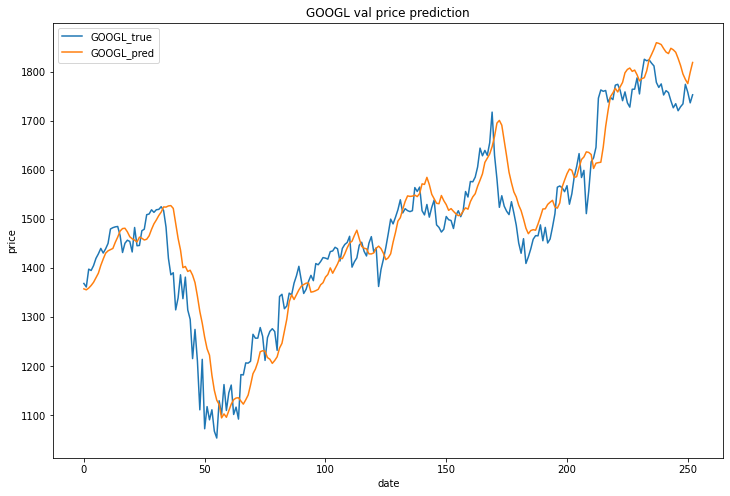

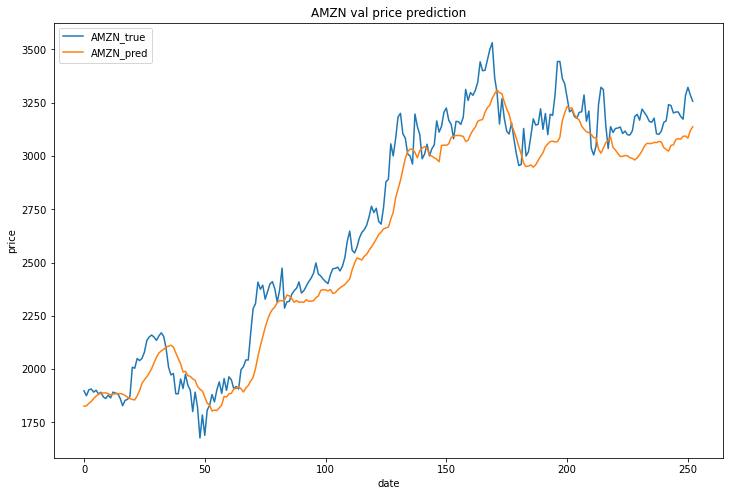

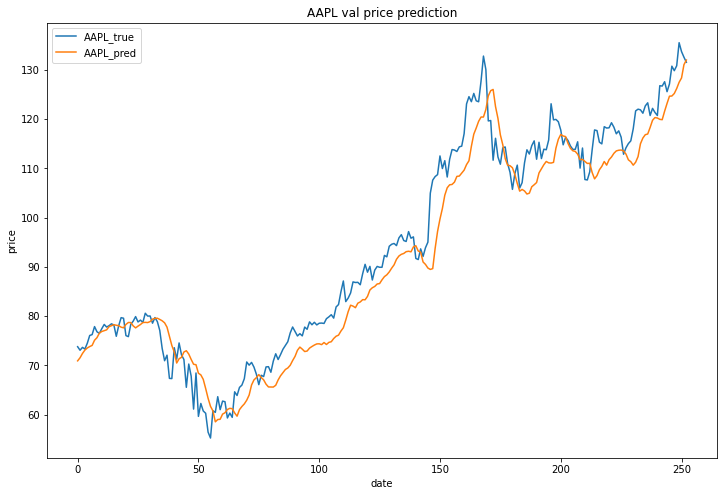

In [30]:
# plotting prediction
batch_size = trial.params['batch_size']
train_gen, val_gen = build_gen(length=length, batch_size=batch_size)
y_pred = sc_y.inverse_transform(best_model.predict(val_gen))
x_ax = np.arange(len(y_pred))
for i in range(len(stocks)):

    plt.figure(figsize=(12,8))
    plt.title(stocks[i]+' val price prediction')
    plt.ylabel('price')
    plt.xlabel('date')
    plt.plot(x_ax, sc_y.inverse_transform(y_val)[length:,i])
    plt.plot(x_ax, y_pred[:,i])
    plt.legend([stocks[i]+'_true', stocks[i]+'_pred'], loc='upper left')
    plt.show()



* This section is a simulation on the day trading, once I already got the predicted price of the next day from the previous section.
* The strategy is, sell all the stocks that would drop the next day. Buy all the stocks that would rise the next day (buy the one with highest rise as much as possible first, then move on to the next one)
* For simplicity, i did not add transaction cost here. that would be an improvement in the future work.

In [31]:
# val final asset

INITIAL_BALANCE = 1e6
STOCKS_DIM = len(stocks)

day = 0
# state = cash + yesterday price + shares
latest_price = sc_y.inverse_transform(y_val)[day+length-1].tolist()
state = [INITIAL_BALANCE] + latest_price + [0]*len(stocks)
total_asset = state[0] + np.array(state[1:1+STOCKS_DIM])*np.array(state[1+STOCKS_DIM:])

def sell_stock(index):
    #update cash
    state[0] += state[index+STOCKS_DIM+1]*state[index+1] 
    # update amount in the port
    state[index+STOCKS_DIM+1] = 0

def buy_stock(index):
    available_amount = state[0] // state[index+1]
    #update cash
    state[0] -= state[index+1]*available_amount
    # update amount in the port
    state[index+STOCKS_DIM+1] += available_amount


while day < len(y_pred):
    change = np.array([(y_pred[day][i] - state[i+1])/state[i+1] for i in range(len(stocks))])
    argsort_actions = np.argsort(change)
    sell_index = argsort_actions[:np.where(change < 0)[0].shape[0]]
    buy_index = argsort_actions[::-1][:np.where(change > 0)[0].shape[0]]
    # sell
    for index in sell_index:
        sell_stock(index)
    # buy
    for index in buy_index:
        buy_stock(index)
        
    # move to the next day
    day += 1    
    latest_price = sc_y.inverse_transform(y_val)[day+length-1].tolist()
    state = [state[0]] + latest_price + state[1+STOCKS_DIM:]
    total_asset = state[0] + sum(np.array(state[1:1+STOCKS_DIM])*np.array(state[1+STOCKS_DIM:]))
    
print(f'final asset: {total_asset}')

final asset: 1532675.206825255


* The performance is significantly better than the baseline model

In [32]:
optuna.visualization.plot_intermediate_values(study)

In [33]:
optuna.visualization.plot_optimization_history(study)

In [34]:
optuna.visualization.plot_parallel_coordinate(study)

In [35]:
optuna.visualization.plot_param_importances(study)